In [1]:
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import scipy.optimize as spo
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Train level 1 model
First, import the training set, and train the model on the existing variables (balance the dataset). 

In [2]:
ds_train = pd.read_hdf('../data/DS_2_train_extended_float32.hdf')
ds_train.columns

Index([u'index', u'event_id', u'X', u'Y', u'Z', u'TX', u'TY', u'chi2',
       u'signal', u'brick_number', u'grid_value', u'smoothgrid_value',
       u'min_sep', u'cone1', u'cone2', u'cone1_1up', u'cone1_1down',
       u'cone1_2up', u'cone1_2down', u'cone1_3up', u'cone1_3down',
       u'cone1_4up', u'cone1_4down', u'cone2_1up', u'cone2_1down',
       u'cone2_2up', u'cone2_2down', u'cone2_3up', u'cone2_3down',
       u'cone2_4up', u'cone2_4down', u'dT1up', u'dT1down', u'dT2up',
       u'dT2down', u'dT3up', u'dT3down', u'dT4up', u'dT4down', u'dR1up',
       u'dR1down', u'dR2up', u'dR2down', u'dR3up', u'dR3down', u'dR4up',
       u'dR4down'],
      dtype='object')

Select your training and test sets:

In [17]:
brick_nb = 60

# determine the training and test sets.
D_train = ds_train[ds_train.brick_number < brick_nb]
D_test = ds_train[ds_train.brick_number >= brick_nb]

X_train = D_train.drop('index', axis=1).drop('event_id', axis=1).drop('signal', axis=1).drop('brick_number', axis=1)
X_test = D_test.drop('index', axis=1).drop('event_id', axis=1).drop('signal', axis=1).drop('brick_number', axis=1)

Y_train = D_train['signal']
Y_test = D_test['signal']

In [18]:
#print n_sig*2
print X_train.shape
print Y_train.shape

(5786065, 43)
(5786065,)


Train the selected model, and report results:

In [19]:
n_est = 16

#model = xgboost.XGBClassifier(n_estimators=n_est, nthread=8, max_depth=2)#, reg_alpha=0, reg_lambda=0.5)
#model = GradientBoostingClassifier(n_estimators=n_est, max_depth=4, loss='exponential')
model = RandomForestClassifier(n_estimators=n_est, max_depth=3, n_jobs=8)
#model = xgboost.XGBClassifier(n_estimators=n_est, nthread=8, max_depth=3)

t1= time.time()
model.fit(X_train, Y_train)
pred_train = model.predict_proba(X_train)[:,1]
pred_test = model.predict_proba(X_test)[:,1]
print 'n_est:', n_est
print 'time taken:', time.time() - t1
print 'train score:', roc_auc_score(Y_train, pred_train)
print 'test score: ', roc_auc_score(Y_test, pred_test)
os.system('say "dataset evaluated"')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=16, n_jobs=8, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

n_est: 16
time taken: 59.8069660664
train score: 0.964352918059
test score:  0.968261020139


0

# Get number of showers
Now get the data for a certain brick, and predict which tracks belong to the signal. Select tracks with prediction greater than 0.5, and use the shower finding algorithm on them.

In [44]:
n = 63
for brick_n in range(n, n+1):
    print 'brick_n', brick_n
    true_n_showers = len(np.unique(np.array(D_test[D_test.brick_number == brick_n]['event_id']))) - 1

    # predict tracks belonging to the shower:
    D_test['prediction'] = pred_test
    showers = D_test[(D_test.prediction > 0.30) & (D_test.brick_number == brick_n)]
    real_showers = D_test[(D_test.signal == 1) & (D_test.brick_number == brick_n)]

    showers.columns
    
    # and show them:
    fig, ax = plt.subplots(2, figsize=(20, 20))
    real_showers.plot.scatter('X', 'Y', c='b', alpha = 0.5, ax=ax[0])
    showers.plot.scatter('X', 'Y', c='r', alpha = 0.5, ax=ax[0])
    real_showers.plot.scatter('Z', 'Y', c='b', alpha = 0.5, ax=ax[1])
    showers.plot.scatter('Z', 'Y', c='r', alpha = 0.5, ax=ax[1])
    #plt.show()

    # now guess the number of showers
    shower_coords = showers[['X', 'Y']]
    shower_pred = list(range(5))
    sil_scores = np.array(range(5), dtype=float)

    max_clusters = min(6, showers.shape[0])
    # compute the kmeans and save the silhouette score
    for n_clus in range(2, max_clusters):
        print 
        print 'n_clust', n_clus
        kmeans = KMeans(n_clusters=n_clus)
        shower_pred[n_clus-1] = kmeans.fit_predict(shower_coords)
        print shower_coords, shower_pred[n_clus-1]
        silhouette_avg = silhouette_score(shower_coords, shower_pred[n_clus-1])
        sil_scores[n_clus-1] = silhouette_avg

        print "Silhouette score avg is:", sil_scores[n_clus-1]

    # determine the number of clusters
    pred_n_showers = np.argmax(sil_scores)+1
    x_sd = np.std(showers['X'])
    y_sd = np.std(showers['Y'])
    sdev = np.sqrt(x_sd**2+y_sd**2)

    # correct for very small number of tracks:
    if showers.shape[0] < 60:
        pred_n_showers = 1
    
    # correct for the 2/1 cluster case
    if pred_n_showers == 2 and sdev < 4500:
        pred_n_showers = 1

    # let us know the outcome
    print 
    print sil_scores
    print 'x_sd', x_sd
    print 'y_sd', y_sd
    print 'standard deviation is:', sdev
    print
    print '###############################'
    print 'True number of clusters is     :', true_n_showers
    print 'Predicted number of clusters is:', pred_n_showers
    print '###############################'
    fig, ax = plt.subplots(2, figsize=(20, 30))
    shower_coords.plot.scatter('X', 'Y', c=shower_pred[true_n_showers-1], cmap='magma', alpha = 1, ax=ax[0])
    shower_coords.plot.scatter('X', 'Y', c=shower_pred[pred_n_showers-1], cmap='magma', alpha = 1, ax=ax[1])
    plt.show()


brick_n 63


/Users/zgubic/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Index([u'index', u'event_id', u'X', u'Y', u'Z', u'TX', u'TY', u'chi2',
       u'signal', u'brick_number', u'grid_value', u'smoothgrid_value',
       u'min_sep', u'cone1', u'cone2', u'cone1_1up', u'cone1_1down',
       u'cone1_2up', u'cone1_2down', u'cone1_3up', u'cone1_3down',
       u'cone1_4up', u'cone1_4down', u'cone2_1up', u'cone2_1down',
       u'cone2_2up', u'cone2_2down', u'cone2_3up', u'cone2_3down',
       u'cone2_4up', u'cone2_4down', u'dT1up', u'dT1down', u'dT2up',
       u'dT2down', u'dT3up', u'dT3down', u'dT4up', u'dT4down', u'dR1up',
       u'dR1down', u'dR2up', u'dR2down', u'dR3up', u'dR3down', u'dR4up',
       u'dR4down', u'prediction'],
      dtype='object')

TypeError: Empty 'DataFrame': no numeric data to plot

# Fit electron tracks
Determine the tracks of all electrons by fitting the X, Y, Z variables of each shower candidates.

In [41]:
class electron:
    def __init__(self, x1, y1, z1, tx, ty):
        self.x1 = x1
        self.y1 = y1
        self.z1 = z1
        self.tx = tx
        self.ty = ty
        
    def get_x_pos(self, z):
        x_pos = self.x1 + z*np.sin(self.tx)
        return x_pos
    
    def get_y_pos(self, z):
        y_pos = self.y1 + z*np.sin(self.ty)
        return y_pos
    
    def get_distance_from(self,x,y,z):
        dx = x - self.get_x_pos(z)
        dy = y - self.get_y_pos(z)
        return (dx**2 + dy**2)**0.5
    
    def get_dTX(self, tx):
        return tx - self.tx
    
    def get_dTY(self, ty):
        return ty - self.ty


/Users/zgubic/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/zgubic/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,X,Y,shower_id,Z
1544598,49085.339844,56169.085938,0,19395.0
4327557,49042.847656,56271.882812,0,19395.0
6178090,49067.421875,56768.238281,0,18102.0
8472936,49062.773438,55884.808594,0,19395.0
9628180,49083.921875,56730.070312,0,19395.0


computing shower 0


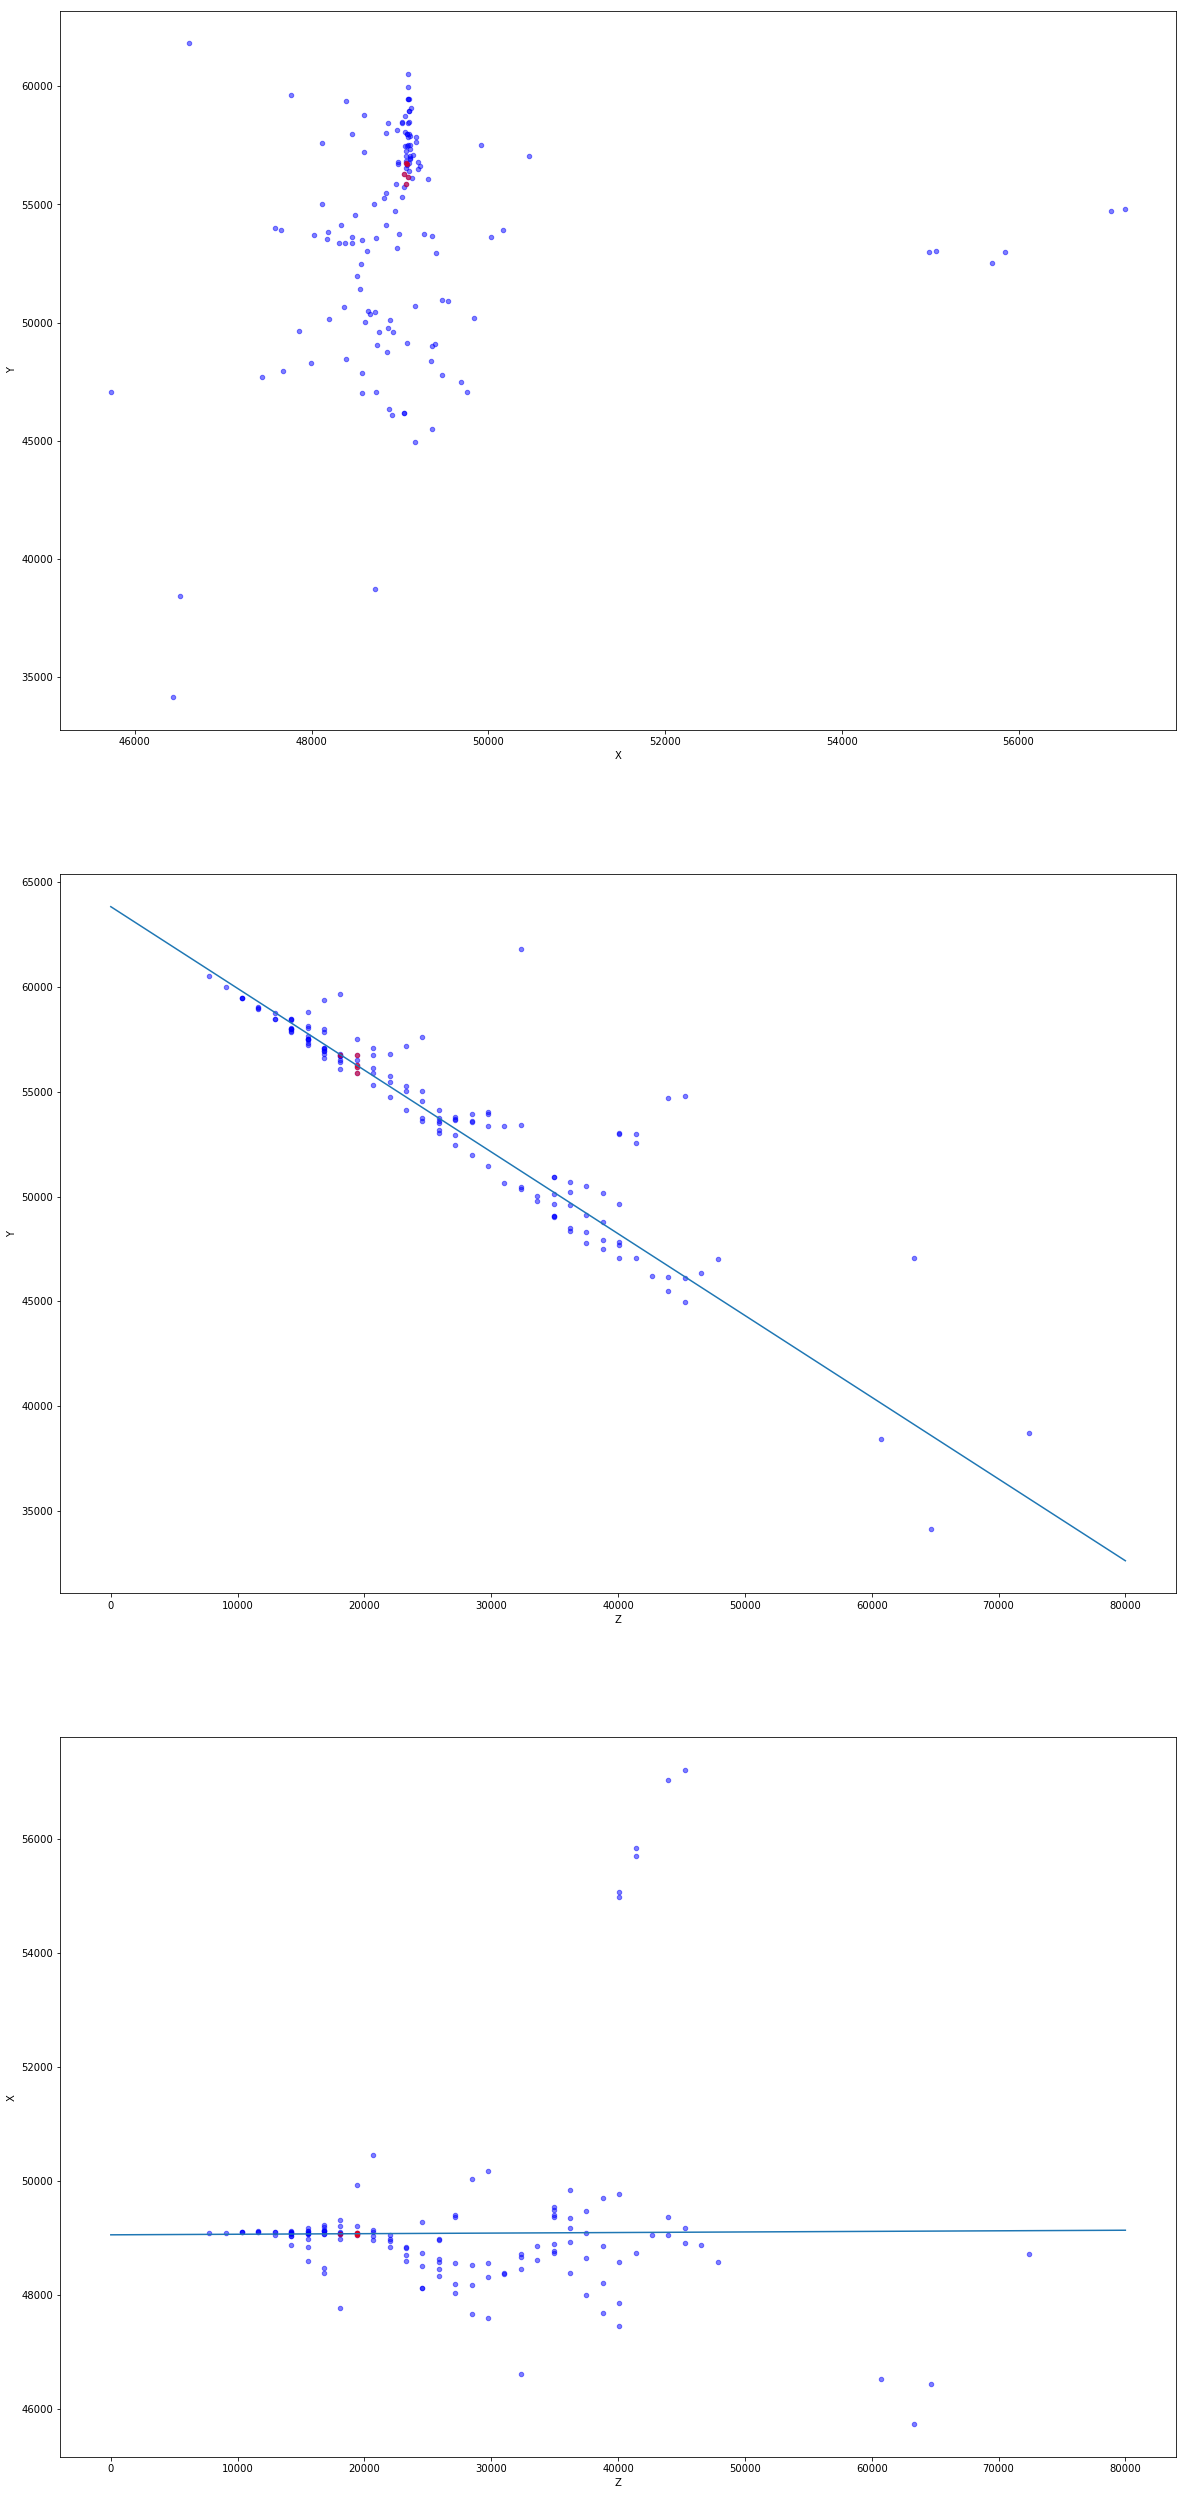

In [42]:
shower_coords['shower_id'] = shower_pred[pred_n_showers-1]
shower_coords['Z'] = showers['Z']
shower_coords.head()

# make the plot that is filled for each shower separately
#fig, ax = plt.subplots(pred_n_showers, figsize=(20, 15*pred_n_showers))

# function to fit
def linear(x, intercept, slope):
    return intercept + x*slope

electrons = []

for sh_i in range(pred_n_showers):

    print 'computing shower', sh_i
    
    # define and plot the shower 
    current_shower = shower_coords[shower_coords.shower_id == sh_i]
    #current_shower.plot.scatter('Z', 'Y', c='k', alpha = 1, ax=ax[sh_i])
    
    # fit a line for electron position
    popt, pcov = spo.curve_fit(linear, current_shower['Z'], current_shower['Y'], p0=[np.mean(current_shower['Y']), 0])
    y0 = popt[0]
    yk = popt[1]
    popt, pcov = spo.curve_fit(linear, current_shower['Z'], current_shower['X'], p0=[np.mean(current_shower['X']), 0])
    x0 = popt[0]
    xk = popt[1]
    zmin = np.min(current_shower['Z'])
    electrons.append(electron(x0, y0, zmin, xk, yk))

# and plot the showers again, with electron tracks
fig, ax = plt.subplots(3, figsize=(20, 45))
# showers
real_showers.plot.scatter('X', 'Y', c='b', alpha = 0.5, ax=ax[0])
showers.plot.scatter('X', 'Y', c='r', alpha = 0.5, ax=ax[0])
real_showers.plot.scatter('Z', 'Y', c='b', alpha = 0.5, ax=ax[1])
showers.plot.scatter('Z', 'Y', c='r', alpha = 0.5, ax=ax[1])
real_showers.plot.scatter('Z', 'X', c='b', alpha = 0.5, ax=ax[2])
showers.plot.scatter('Z', 'X', c='r', alpha = 0.5, ax=ax[2])
# electrons
zs = np.linspace(0,80000)
for i in range(pred_n_showers):
    e = electrons[i]
    ys = linear(zs, e.y1, e.ty)
    ax[1].plot(zs, ys)
    xs = linear(zs, e.x1, e.tx)
    ax[2].plot(zs, xs)


plt.show()

# Compute variables
Compute the variables related to these electorn tracks and store them in a csv file. Variables:
- Distance to closest electron track in X, Y plane
- Difference in angle to the closest electron track
- How far along Z of the shower you are

In [234]:
###########################
# Now take all the tracks in the set and compute the distance to the electron path
###########################
tracks_xs = D_test['X']
tracks_ys = D_test['Y']
tracks_zs = D_test['Z']

# compute the distance of each track to each electron
distances = np.zeros(shape=(len(tracks_xs), len(electrons)))
for i, elec in enumerate(electrons):
    distances[:,i] = elec.get_distance_from(tracks_xs, tracks_ys, tracks_zs)
print 'distances', distances

# get the index of the closest electron for each track
closest_e = distances.argsort()[:, 0]
print 'el_indices', el_indices

# compute the dTheta from the closest electorn track, and dZ (distance along Z from the start of the shower)
dR = np.zeros(len(tracks_xs))
dT = np.zeros(len(tracks_xs))
dZ = np.zeros(len(tracks_xs))

for tr_i in range(len(D_test)):
#for tr_i in range(5):
    #print
    #print 'track ', tr_i
    e_i = closest_e[tr_i]
    dTX = electrons[e_i].get_dTX(D_test.iloc[tr_i]['TX'])
    dTY = electrons[e_i].get_dTY(D_test.iloc[tr_i]['TY'])
    #print 'dTX', dTX
    #print 'dTY', dTY
    dT[tr_i] = np.sqrt(dTX**2 + dTY**2)
    dZ[tr_i] = electrons[e_i].z1 - D_test.iloc[tr_i]['Z']

# and save the smallest distances
dR = np.min(distances, axis=1)
    
print
print 'dR', dR
print 'dT', dT
print 'dZ', dZ

###########################
# and finally add to the dataset:
# - minimum distances to electrons
# - differences in angles to nearest electrons
###########################

final = D_test[['index', 'signal']]
final['e_dR'] = dR
final['e_dT'] = dT
final['e_dZ'] = dZ

sig = final[final.signal == 1]
bkg = final[final.signal == 0]

#os.system('say "finished"')

distances [[ 11858.25371045  34184.72765509  41455.33088611]
 [  6940.61240661  27916.72638426  27947.01100907]
 [ 37919.63427294  27910.84185397  15646.35628085]
 ..., 
 [ 10006.30625467  27108.23209198  33769.50197929]
 [ 28061.32755563  28822.7728819   43479.97557583]
 [ 41597.10772866  21378.78603524  14538.22603131]]
el_indices [0 0 2 ..., 0 0 2]

dR [ 11858.25371045   6940.61240661  15646.35628085 ...,  10006.30625467
  28061.32755563  14538.22603131]
dT [ 0.51476274  0.59057168  0.5232246  ...,  0.62965533  0.43173562
  0.61040526]
dZ [ 29739. -16809.  15516. ..., -42669. -41376.  -7758.]


/Users/zgubic/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zgubic/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zgubic/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

# Test the computed distributions

Make sure there is separation between the signal and the background

,index,signal,e_dR,e_dT,e_dZ
1,1,0.0,11858.253710,0.514763,29739.0
13,13,0.0,6940.612407,0.590572,-16809.0
23,23,0.0,15646.356281,0.523225,15516.0
39,39,0.0,30938.802414,0.478527,-1293.0
40,40,0.0,20022.223248,0.153542,-41376.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x29ef3e790>], dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x29ef3e790>], dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x29a4f3310>], dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x29a4f3310>], dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2d9d4a190>], dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2d9d4a190>], dtype=object)

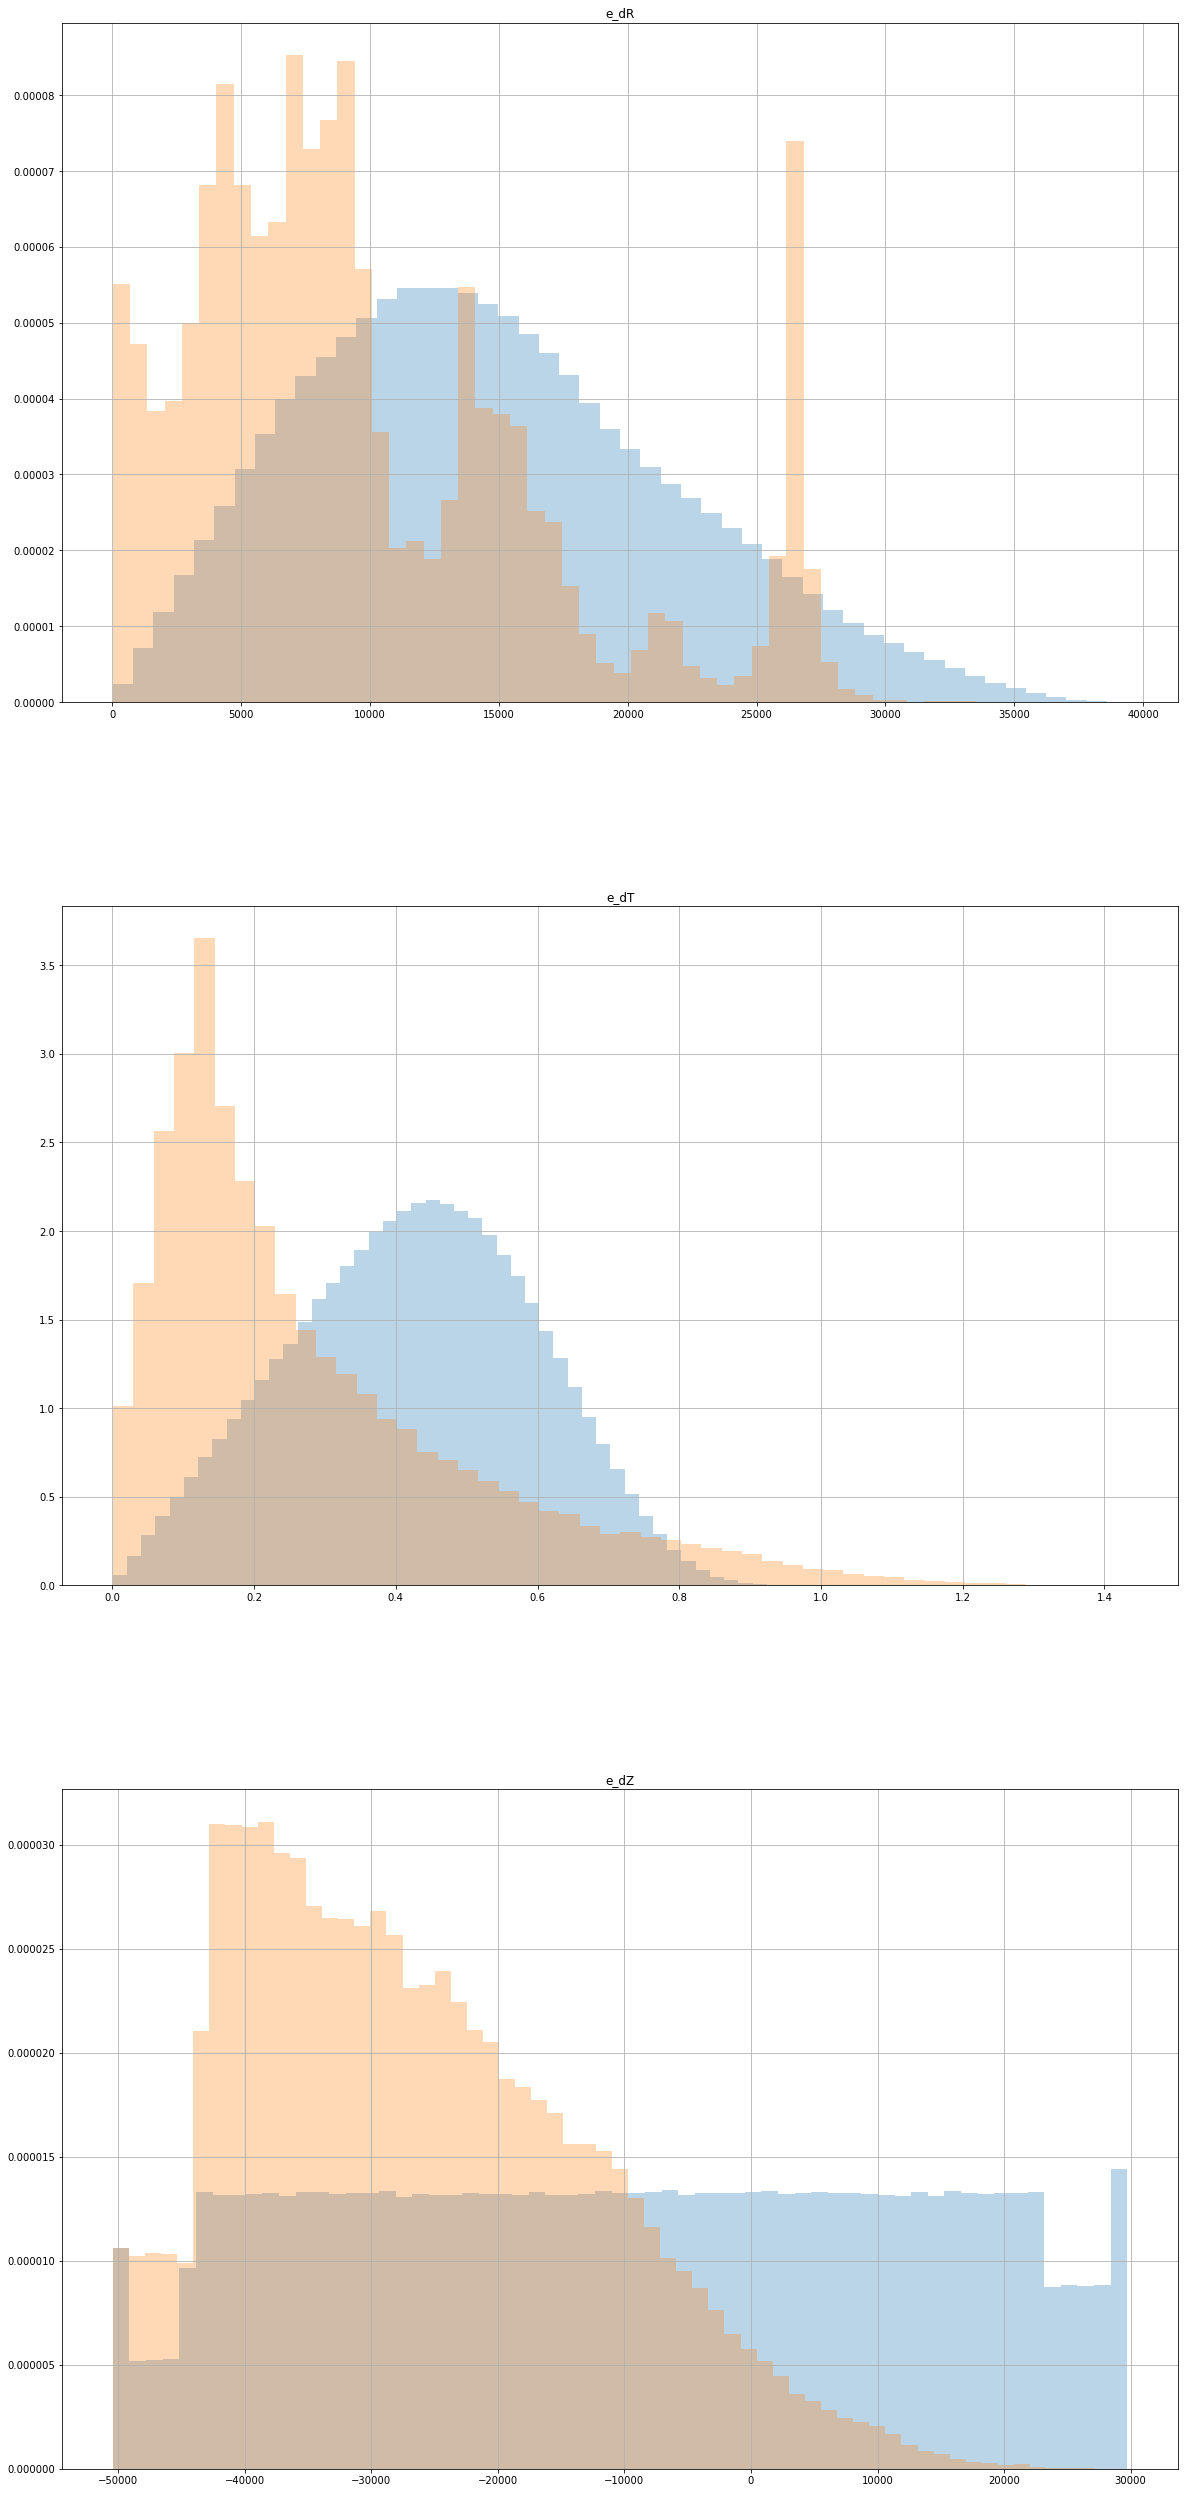

In [243]:
final.head()

fig, ax = plt.subplots(3, figsize=(20, 45))
bkg.hist('e_dR', alpha = 0.3, ax=ax[0], normed=True, bins=50)
sig.hist('e_dR', alpha = 0.3, ax=ax[0], normed=True, bins=50)
bkg.hist('e_dT', alpha = 0.3, ax=ax[1], normed=True, bins=50)
sig.hist('e_dT', alpha = 0.3, ax=ax[1], normed=True, bins=50)
bkg.hist('e_dZ', alpha = 0.3, ax=ax[2], normed=True, bins=61)
sig.hist('e_dZ', alpha = 0.3, ax=ax[2], normed=True, bins=61)
plt.show()